In [1]:
import numpy as np
import nrrd
from os.path import *
import scipy.ndimage
from scipy.optimize import curve_fit
from pylab import *
import matplotlib.patches as mpatches
from JSONread import *
from density_function import *
import json

DATA_FOLDER = "data/"
OUTPUT_FOLDER = "output/"

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Loading annotations
annotation, h = nrrd.read(join(DATA_FOLDER, "annotations.nrrd"))
old_ann, h = nrrd.read(join(DATA_FOLDER, "annotation_25_2017.nrrd"))
jsontextfile = open(join(DATA_FOLDER, "brain_regions.json"), "r")
jsoncontent = json.loads(jsontextfile.read())
search_children(jsoncontent['msg'][0])

In [4]:
marker_names = ["PV", "SST", "VIP"]
SST_volume = np.load(join(DATA_FOLDER, "1001_SST_expr.npy"))
VIP_volume = np.load(join(DATA_FOLDER, "77371835_VIP_expr.npy"))
PV_volume = np.load(join(DATA_FOLDER, "868_pvalb_expr.npy"))
rv = json.loads(open(join(DATA_FOLDER, "volumes_25.json"), "r").read())
literature_file = join(DATA_FOLDER, "densities.xlsx")
sheet_indices = [0]
num_first_row = 2
column_name = 1
columns_mean = [[3, 5], [7, 9], [11, 13]]
num_marker = len(marker_names)

In [5]:
uniques = find_unique_regions(annotation, 
                        id_to_region_dictionary_ALLNAME, 
                        region_dictionary_to_id_ALLNAME,
                        region_dictionary_to_id_ALLNAME_parent, 
                        name2allname)

children, order_ = find_children(uniques, id_to_region_dictionary_ALLNAME, is_leaf,
                                  region_dictionary_to_id_ALLNAME_parent, 
                                  region_dictionary_to_id_ALLNAME)

In [6]:
lim_VIP=[ 56, 538]
VIP_slices = np.array([ 56,  64,  73,  80,  97, 105, 113, 121, 129, 145, 153, 161, 167,
       178, 186, 194, 202, 210, 218, 226, 235, 259, 267, 275, 283, 292,
       300, 308, 316, 324, 341, 349, 357, 365, 382, 390, 398, 407, 415,
       423, 431, 439, 447, 456, 464, 472, 480, 489, 497, 505, 513, 522,
       530, 538])[:-2]
lim_SST=[64, 391]
SST_slices = np.array([ 64,  72,  80,  88,  96, 104, 112, 120, 128, 136, 144, 152, 160,
       168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264,
       272, 280, 288, 296, 303, 311, 319, 328, 335, 343, 351, 359, 367,
       375, 383, 391])
lim_PV =[49, 511]
PV_slices = np.array([ 49,  57,  74,  82,  91, 100, 109, 117, 126, 134, 144, 152, 160,
       169, 177, 186, 195, 203, 211, 220, 228, 236, 245, 254, 262, 270,
       279, 287, 295, 304, 312, 321, 329, 338, 346, 354, 362, 371, 379,
       387, 395, 403, 411, 419, 428, 436, 445, 453, 461, 470, 478, 486,
       494, 502, 511])

In [7]:
# Plot sagital view of the brain to show slices of PV, SST and VIP
np.random.seed(182)
random_amplitudes = np.random.rand(np.max(uniques))
slice_ = int(annotation.shape[2] // 2.5)
fig = figure(figsize=(15, 30))
ax = subplot2grid((30, 1), (0,0), rowspan=10)
ax.imshow(random_amplitudes[annotation[:, :, slice_]].T, interpolation="nearest")
for i in VIP_slices:
    ax.axvline(x=[i], color='r', linewidth=1)
ax.set_title('VIP slices positions')

ax = subplot2grid((30, 1), (10,0), rowspan=10)
ax.imshow(random_amplitudes[annotation[:, :, slice_]].T, interpolation="nearest")
for i in SST_slices:
    ax.axvline(x=[i], color='r', linewidth=1)
ax.set_title('SST slices positions')

ax = subplot2grid((30, 1), (20,0), rowspan=10)
ax.imshow(random_amplitudes[annotation[:, :, slice_]].T, interpolation="nearest")
for i in PV_slices:
    ax.axvline(x=[i], color='r', linewidth=1)
ax.set_title('PV slices positions')
tight_layout()
savefig(join(OUTPUT_FOLDER, 'slices.png'), dpi=400)
close(fig)

In [10]:
names, marker_means, down_std_literature, _, convert = read_densities_sheet(
                    literature_file, region_keys, columns_mean,
                    sheet_indices, num_first_row, column_name)

PVs = marker_means[0]
PVs_std = PVs - down_std_literature[0]
SSTs = marker_means[1]
SSTs_std = SSTs - down_std_literature[1]
VIPs = marker_means[2]
VIPs_std = VIPs - down_std_literature[2]

In [11]:
# Conversion dictionary from Kim to CCF
convert["Whole brain"] = ["Basic cell groups and regions"]
convert["Anterior cingulate area, ventral part, 6"] = ["Anterior cingulate area, layer 6a", "Anterior cingulate area, layer 6b"]

for old, new in dict_corrections.items():
    old_name = id_to_region_dictionary[new[0]]+'/3'
    if old_name in convert.keys():
        convert[old_name] = [id_to_region_dictionary[inew] for inew in new]

for id_, name in id_to_region_dictionary.items():
    if "layer 6" in name or "Layer 6" in name:
        if name[:-1] in convert.keys():
            convert[name[:-1]].append(name)

# Regions not found: regions which are merged in CCF mostly
print("Regions without CCF equivalent:")
for k,v in convert.items():
    if len(v)==0:
        print(k)

Regions without CCF equivalent:
Nucleus accumbens, core
Nucleus accumbens, shell

Nucleus of reunions
Periaqueductal gray, dorsal lateral
Periaqueductal gray, dorsal medial
Periaqueductal gray, lateral
Periaqueductal gray, ventral lateral


In [12]:
expressions = [[[],[],[]],[[],[],[]],[[],[],[]]]
densities = [[[],[],[]],[[],[],[]],[[],[],[]]]
dens_stds = [[[],[],[]],[[],[],[]],[[],[],[]]]
names_corrected = [[[],[],[]],[[],[],[]],[[],[],[]]]
percent_done = 0
SST_filt = np.ones(annotation.shape[0], dtype=bool)
SST_filt[SST_slices] = False
VIP_filt = np.ones(annotation.shape[0], dtype=bool)
VIP_filt[VIP_slices] = False
PV_filt = np.ones(annotation.shape[0], dtype=bool)
PV_filt[PV_slices] = False

for iname, name in enumerate(names):
    current_percent = min(int(float(iname) / float(len(names)) * 100.), 100)
    if current_percent > percent_done:
        progress_bar(current_percent)
        percent_done = current_percent

    if name in convert.keys():
        if len(convert[name])==0:
            continue
        filter_ = np.zeros(annotation.shape, dtype=bool)
#         volume = 0
        not_leaf = False
        for converted in convert[name]:
            allname = name2allname[converted]
            if is_leaf[allname]:
                filter_ = np.logical_or(filter_, annotation==region_dictionary_to_id[converted])
#                 volume += rv[allname]
            else: 
                not_leaf = True
                print(name)
                break
        if not_leaf:
            continue
    else:
        allname = name2allname[name]
        if is_leaf[allname]:
            filter_ = annotation==region_dictionary_to_id[name]
        else: filter_ = np.in1d(annotation,  np.concatenate((children[allname], [region_dictionary_to_id[name]]))).reshape(annotation.shape)

    if allname.find("Cerebellum")>=0 or allname.find("arbor vitae")>=0:
        place_ = 0
    elif len(np.where(old_ann==region_dictionary_to_id_ALLNAME[allname])[0])==0:
        continue
    elif allname.find("Isocortex")>=0 or allname.find("Entorhinal area")>=0 or allname.find("Piriform area")>=0:
        if "ayer 1" in allname:
            continue
        place_ = 1
    else:
        place_ = 2
    new_filt = np.copy(filter_)
    new_filt[SST_filt]=False
    if np.any(new_filt):
#     z_slices = np.unique(np.where(filter_)[0])
#     if not (np.any(filter_[0:lim_SST[0],:,:]) or np.any(filter_[min(lim_SST[1], 528):528,:,:]))\
#         and np.any(np.in1d(z_slices, SST_slices)):
#         and (float(SSTs[iname])==0 or float(SSTs_std[iname])/float(SSTs[iname])<=0.05):
        expressions[place_][0].append(np.mean(SST_volume[new_filt]))
        densities[place_][0].append(float(SSTs[iname]))
        dens_stds[place_][0].append(float(SSTs_std[iname]))
        names_corrected[place_][0].append(name)
    new_filt = np.copy(filter_)
    new_filt[VIP_filt]=False
    if np.any(new_filt):
#     if not (np.any(filter_[0:lim_VIP[0],:,:]) or np.any(filter_[min(lim_VIP[1], 528):528,:,:]))\
#         and np.any(np.in1d(z_slices, VIP_slices)):
#         and (float(VIPs[iname])==0 or float(VIPs_std[iname])/float(VIPs[iname])<=0.05):
        expressions[place_][1].append(np.mean(VIP_volume[new_filt]))
        densities[place_][1].append(float(VIPs[iname]))
        dens_stds[place_][1].append(float(VIPs_std[iname]))
        names_corrected[place_][1].append(name)
    new_filt = np.copy(filter_)
    new_filt[PV_filt]=False
    if np.any(new_filt):
#     if not (np.any(filter_[0:lim_PV[0],:,:]) or np.any(filter_[min(lim_PV[1], 528):528,:,:]))\
#         and np.any(np.in1d(z_slices, PV_slices)):
#         and (float(PVs[iname])==0 or float(PVs_std[iname])/float(PVs[iname])<=0.05):
        expressions[place_][2].append(np.mean(PV_volume[new_filt]))
        densities[place_][2].append(float(PVs[iname]))
        dens_stds[place_][2].append(float(PVs_std[iname]))
        names_corrected[place_][2].append(name)
    
progress_bar(100)
densities = np.array(densities)
dens_stds = np.array(dens_stds)
names_corrected = np.array(names_corrected)
expressions = np.array(expressions)

[====================================================================================================] 100%


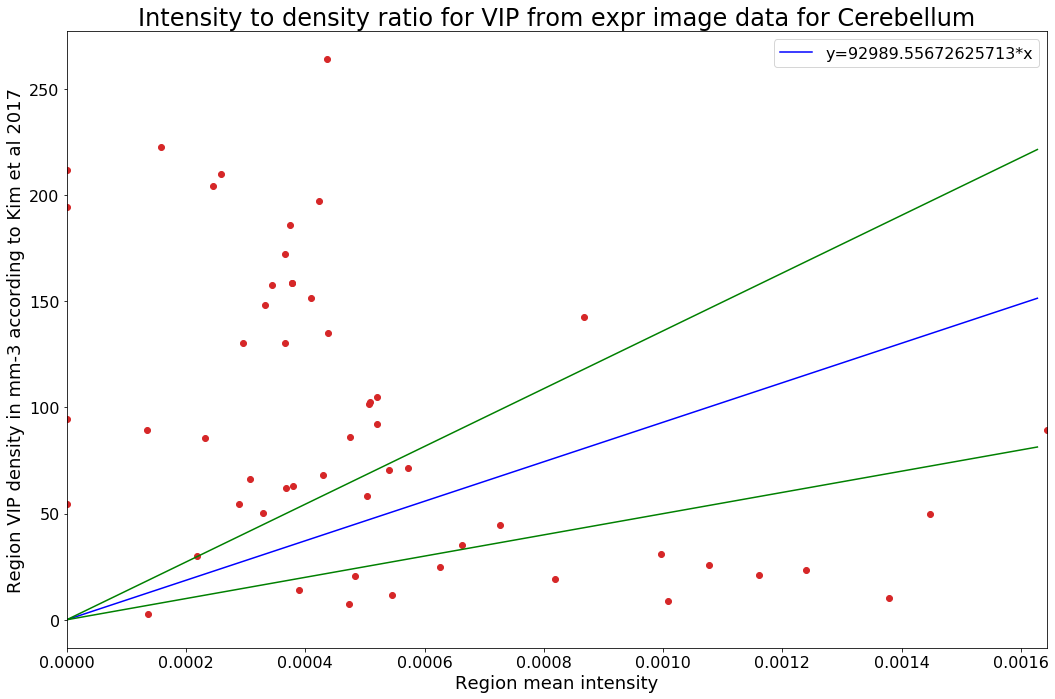

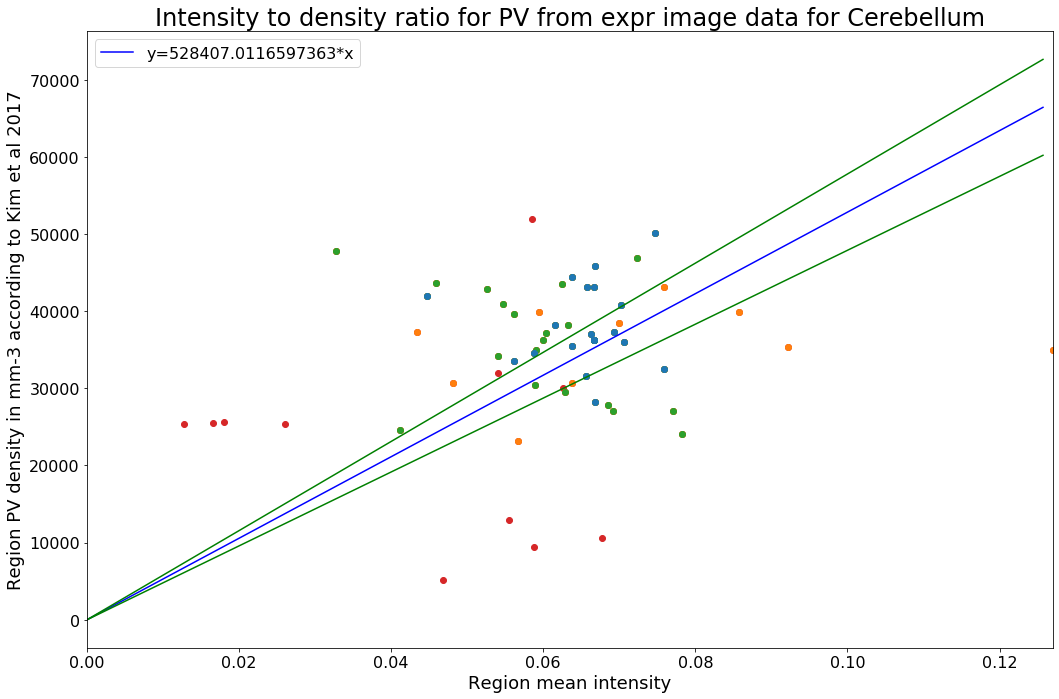

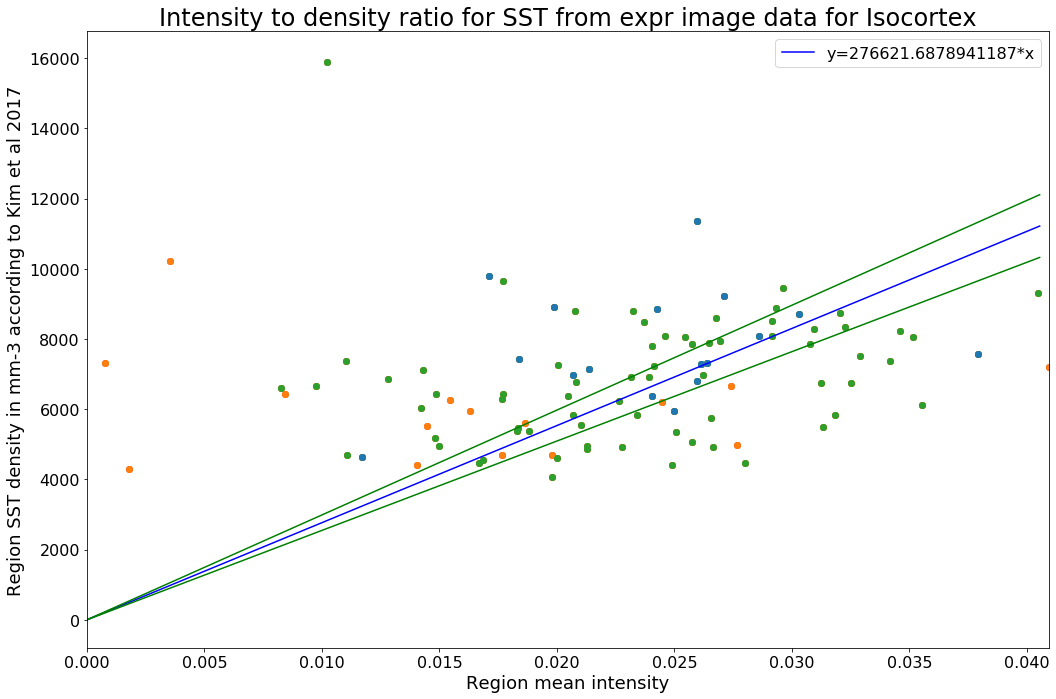

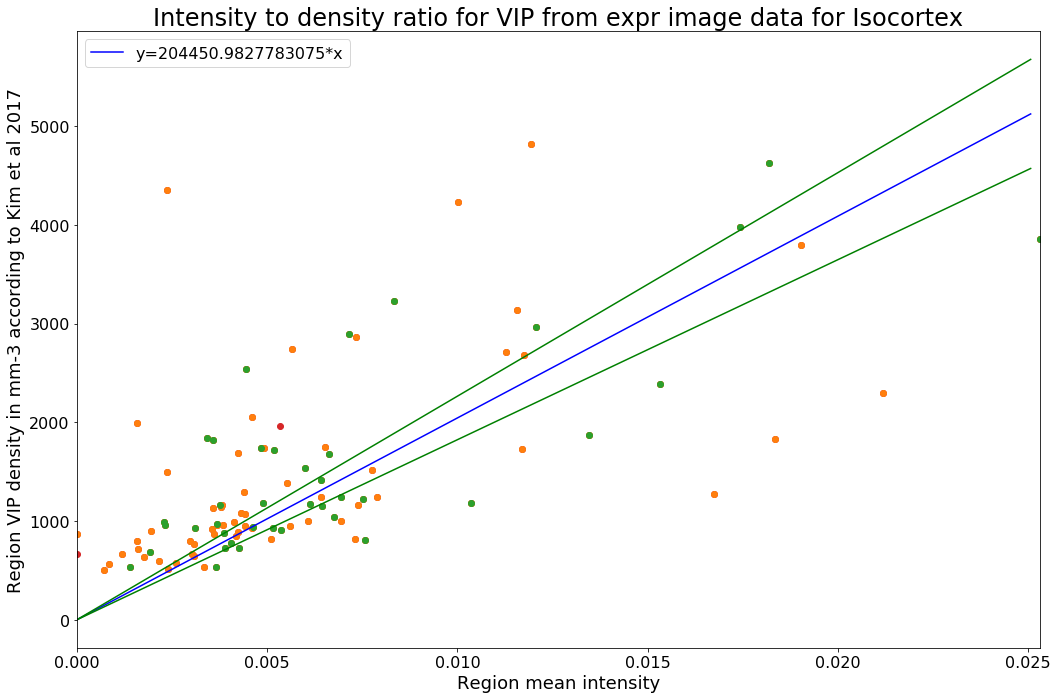

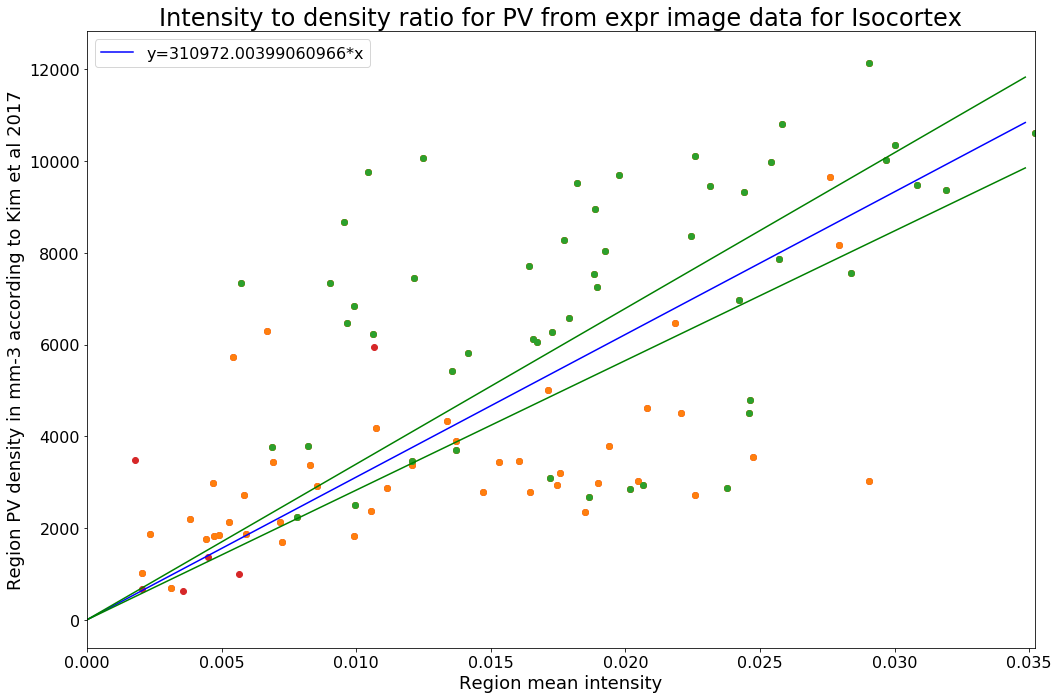

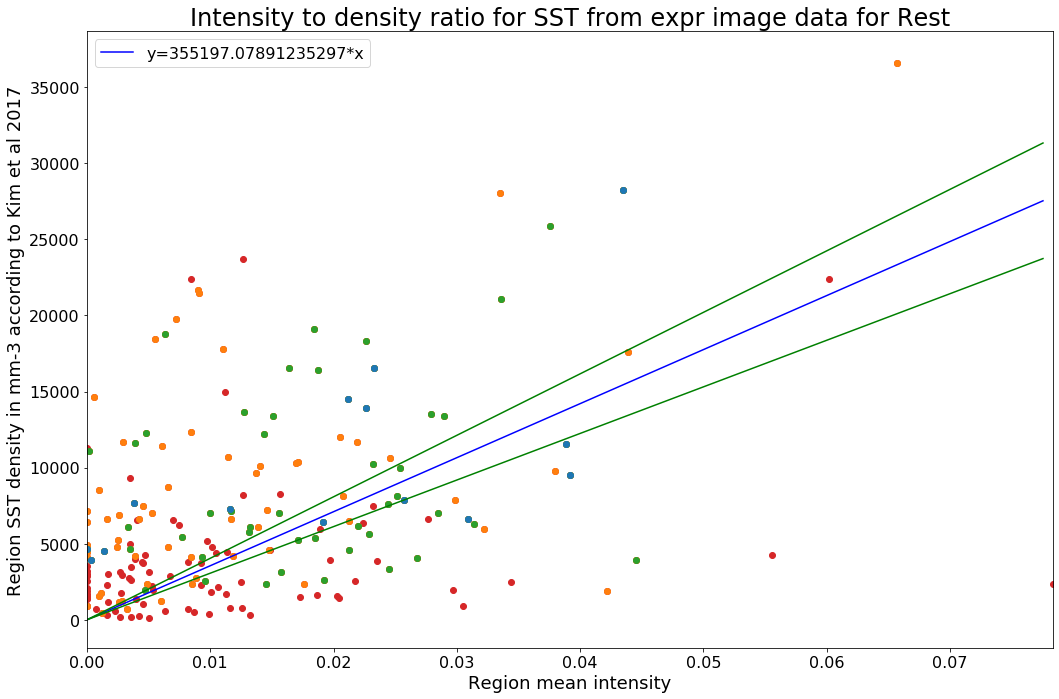

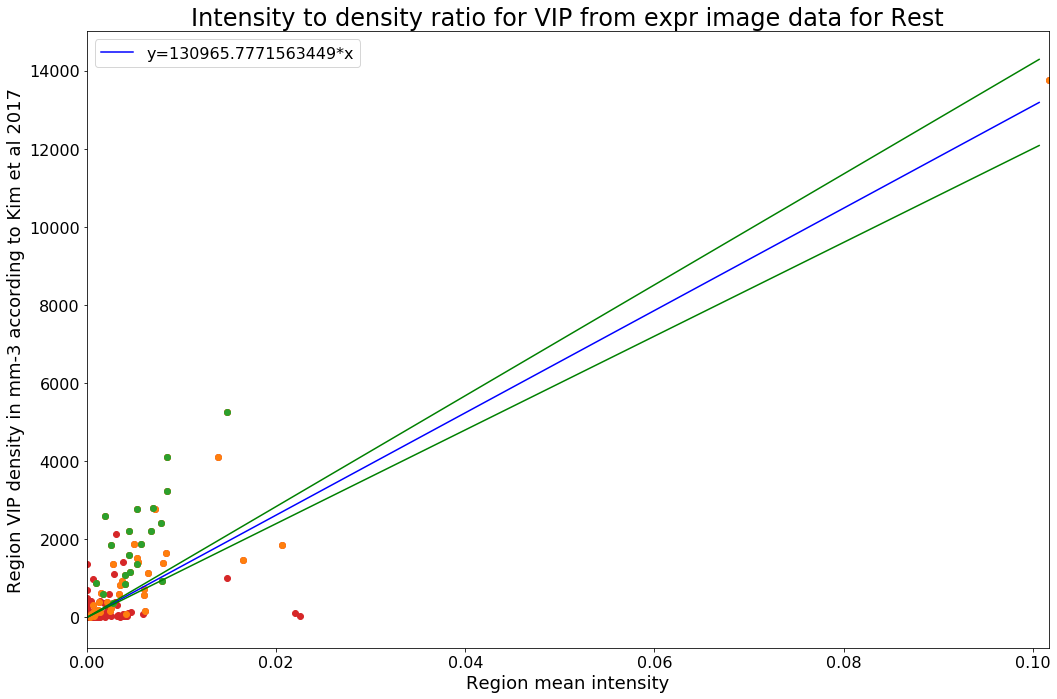

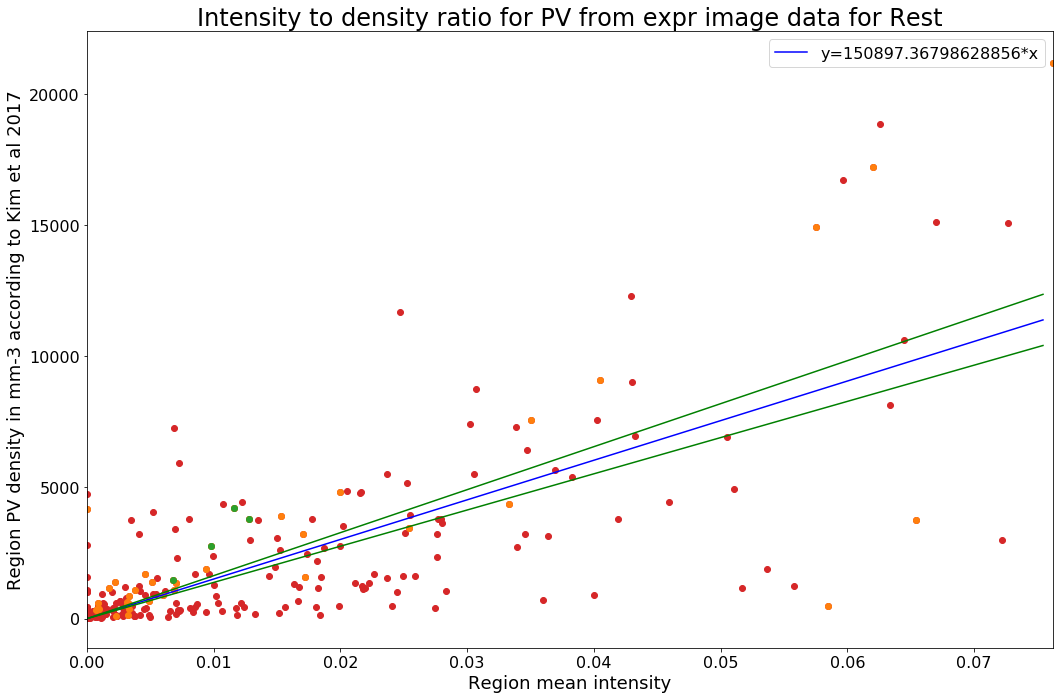

In [30]:
optimize_func = lambda x, alpha: alpha*x
alphas = {"SST":{}, "VIP":{}, "PV":{}}
stds = {"SST":{}, "VIP":{}, "PV":{}}
for ireg, region in enumerate(['Cerebellum', 'Isocortex', 'Rest']):
    for imarker, marker in enumerate(["SST", "VIP", "PV"]):
        density = np.array(densities[ireg][imarker])
        dens_std = np.array(dens_stds[ireg][imarker])
        expression = np.array(expressions[ireg][imarker])
        name = np.array(names_corrected[ireg][imarker])

        filter_ = (~np.isnan(expression))*(density>0)
        if np.any(filter_):
            figure(figsize=(15,10))
            expression = expression[filter_]
            density = density[filter_]
            name = name[filter_]
            dens_std = dens_std[filter_]

            max_ = np.max(expression)
            for i, percent in zip([3,1,2,0],[1.0, 0.2,0.1, 0.05]):
                filter_ = (dens_std/density<percent)
                scatter(expression[filter_], density[filter_], c=rcParams['axes.prop_cycle'].by_key()['color'][i])
            x = linspace(0, max_, 100, endpoint=False, dtype=float)

            solution, pcov = curve_fit(optimize_func, 
                        xdata=expression, 
                        ydata=density)
            # Display bined standard deviation and name of the points outside it
#             low_std = []
#             high_std = []
#             for i in range(len(x)//2-1):
#                 filter_ = (expression >= x[i*2])*(expression<x[(i+1)*2])
#                 if np.any(filter_):
#                     error = np.sqrt(np.sum(np.power(density[filter_] - solution[0]*expression[filter_], 2)) / len(density[filter_]))
#                     low_std.append(max(x[i*2]*solution[0]-error, 0.))
#                     high_std.append(x[i*2]*solution[0]+error)
#                 else:
#                     low_std.append(x[i*2]*solution[0])
#                     high_std.append(x[i*2]*solution[0])
#                 out_std = (density[filter_]<low_std[-1])+(density[filter_]>high_std[-1])
#                 for i, n in enumerate(name[filter_][out_std]):
#                     annotate(n, (expression[filter_][out_std][i], density[filter_][out_std][i]))
#             fill_between(x[:-2:2],low_std, high_std, alpha=0.5, color=rcParams['axes.prop_cycle'].by_key()['color'][0])
            plot(x, solution[0]*x, 'b', label='y='+str(solution[0])+"*x") 
            plot(x, (solution[0]-2*np.sqrt(pcov[0]))*x, 'g') 
            plot(x, (solution[0]+2*np.sqrt(pcov[0]))*x, 'g') 
            alphas[marker][region] = solution[0]
            stds[marker][region] = np.sqrt(pcov[0])[0]
            xlim([0, max_])
            ylabel("Region "+marker+" density in mm-3 according to Kim et al 2017")
            xlabel("Region mean intensity")
            title("Intensity to density ratio for "+marker+" from expr image data for "+region)
            legend()
            tight_layout()
            savefig(join(OUTPUT_FOLDER, 'expr', region+"_"+marker+"_ratio_expr.png"), dpi=400)

In [34]:
print("Alphas: " + str(alphas))
print("Standard deviation: " + str(stds))
for name in marker_names:
    with open(join(OUTPUT_FOLDER, "fitting_" + name + ".json"), 'w') as fp:
        json.dump({"alphas": alphas[name], "std": stds[name]}, fp, indent=4)

Alphas: {'SST': {'Isocortex': 276621.6878941187, 'Rest': 355197.07891235297}, 'VIP': {'Cerebellum': 92989.55672625713, 'Isocortex': 204450.9827783075, 'Rest': 130965.7771563449}, 'PV': {'Cerebellum': 528407.0116597363, 'Isocortex': 310972.00399060966, 'Rest': 150897.36798628856}}
Standard deviation: {'SST': {'Isocortex': 11018.816027256584, 'Rest': 24490.433237436457}, 'VIP': {'Cerebellum': 21510.736930951673, 'Isocortex': 11022.869619179162, 'Rest': 5476.262291165562}, 'PV': {'Cerebellum': 24727.523684991287, 'Isocortex': 14198.304285379756, 'Rest': 6461.41066138794}}


In [16]:
# Color patches for confidence levels
figure(figsize=(5,5))
labels = ['< {0}% std/value'.format(i*100.) for i in [1.0, 0.2, 0.1, 0.05]]
patches = [mpatches.Patch(color=rcParams['axes.prop_cycle'].by_key()['color'][color], label=label) for label, color in zip(labels, [3,1,2,0])]
axis("off")
legend(patches, labels, loc='center', title='Confidence')
tight_layout()
savefig(join(OUTPUT_FOLDER, 'expr', 'confidence.png'), dpi=400)

NameError: name 'mpatches' is not defined

<Figure size 360x360 with 0 Axes>

# Additional plots
## Volume comparison

In [ ]:
wb2 = xlrd.open_workbook(join(DATA_FOLDER, "volumes.xlsx")) 
sheet2 = wb2.sheet_by_index(0)
volumes = [0.0] * len(names) 
volumes_std = [0.0] * len(names)
for i_region in range(sheet2.nrows-3): 
    if "N/D" not in [sheet2.cell_value(i_region+2, i) for i in range(3, 6, 2)]:
        name = sheet2.cell_value(i_region+2, 1).replace("\xc3\x88", "e")
        if name in names:
            i_name = names.index(name)
            volumes[i_name]=(sheet2.cell_value(i_region+2, 3) + sheet2.cell_value(i_region+2, 5))/2
            volumes_std[i_name]=(sheet2.cell_value(i_region+2, 4) + sheet2.cell_value(i_region+2, 6))/2
volumes = np.array(volumes)
            
CA_volumes = [0.0]*len(names)
for iname, name in enumerate(names):
    if name in convert.keys():
        for converted in convert[name]:
            CA_volumes[iname] += rv[name2allname[converted]]
    else:
        CA_volumes[iname]=rv[name2allname[name]]
CA_volumes = np.array(CA_volumes)

In [ ]:
figure(figsize=(15,10))
scatter(CA_volumes[volumes>0]/1e9,volumes[volumes>0])
ylabel("Region volume in mm according to Kim et al 2017")
xlabel("Region volume in mm according to Cell Atlas")
title("Region volumes comparison.")
legend()
tight_layout()
savefig(join(OUTPUT_FOLDER, "region_volumes_comp.png"), dpi=400)

## Standard deviation of standard deviation

In [ ]:
for imarker, marker in enumerate(["SST", "VIP", "PV"]):
    density = []
    dens_std = []
    name = []
    for ireg, region in enumerate(['Cerebellum', 'Isocortex', 'Rest']):
        density = np.concatenate((density, densities[ireg][imarker]))
        dens_std = np.concatenate((dens_std, dens_stds[ireg][imarker]))
        name = np.concatenate((name, names_corrected[ireg][imarker]))
    filter_ = (~np.isnan(density))
    if np.any(filter_):
        density = density[filter_]
        name = name[filter_]
        dens_std = dens_std[filter_]
        
        figure(figsize=(15,10))
        x = linspace(0, np.max(density), 100, endpoint=False, dtype=float)
        low_std = []
        high_std = []
        mean_ = []
        for i in range(len(x)//2-1):
            filter_ = (density >= x[i*2])*(density<x[(i+1)*2])
            mean_.append(np.mean(dens_std[filter_]))
            std_ = np.std(dens_std[filter_])
            if np.any(filter_):
                low_std.append(max(mean_[-1]-std_, 0.))
                high_std.append(mean_[-1]+std_)
            else:
                low_std.append(mean_[-1])
                high_std.append(mean_[-1])
        scatter(density, dens_std)
        fill_between(x[:-2:2],low_std, high_std, alpha=0.5, color=rcParams['axes.prop_cycle'].by_key()['color'][0])
        plot(x[:-2:2], mean_, 'r')
        tight_layout()
        savefig(join(OUTPUT_FOLDER, marker+"_dens_std.png"), dpi=400)
        close('all')